In [86]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller

from utils import plot_per_dates, print_fuller_test, best_arima_coeffs, plot_prediction, best_alpha


In [87]:
rmses = {}

### Підготовка данних

In [88]:
df = pd.read_csv('./covid.csv')
df = df.drop(labels=['Province/State', 'Lat', 'Long', 'Recovered', 'Deaths', 'Country/Region'], axis=1)
df = df.groupby('Date').sum()
df = df.reset_index()
df['DailyConfirmed'] = df['Confirmed'].diff()
df.loc[df.index[0], 'DailyConfirmed'] = df['Confirmed'].iloc[0]
df.head()

,Date,Confirmed,DailyConfirmed
0,2020-01-22,555,555.0
1,2020-01-23,654,99.0
2,2020-01-24,941,287.0
3,2020-01-25,1434,493.0
4,2020-01-26,2118,684.0


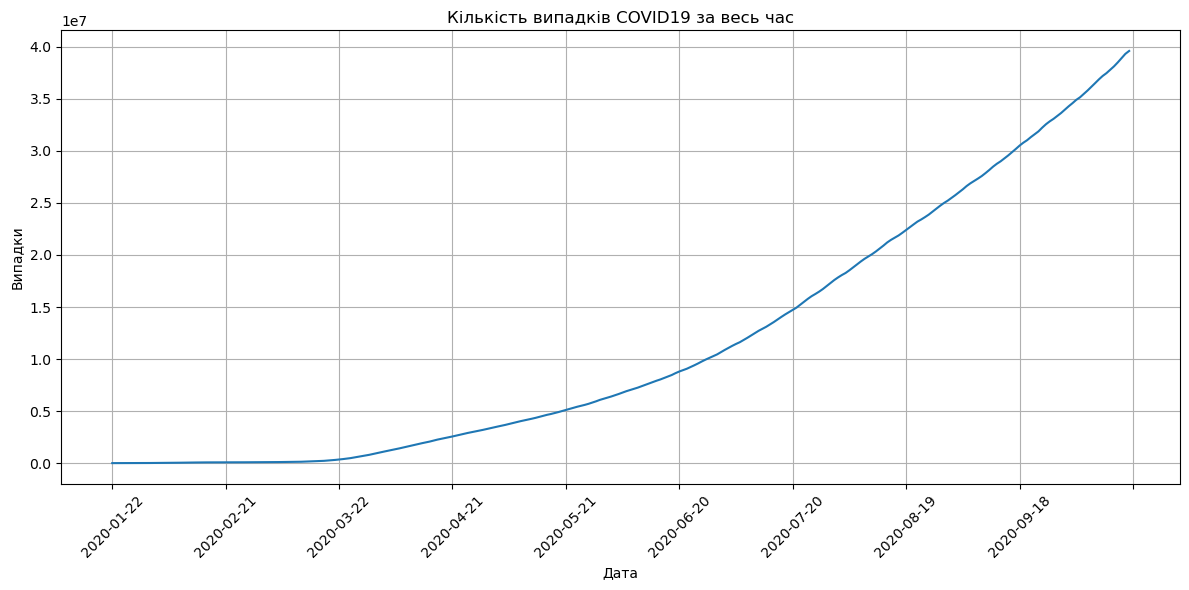

In [89]:
plot_per_dates(df['Date'], df['Confirmed'], 'Кількість випадків COVID19 за весь час', 'Випадки')

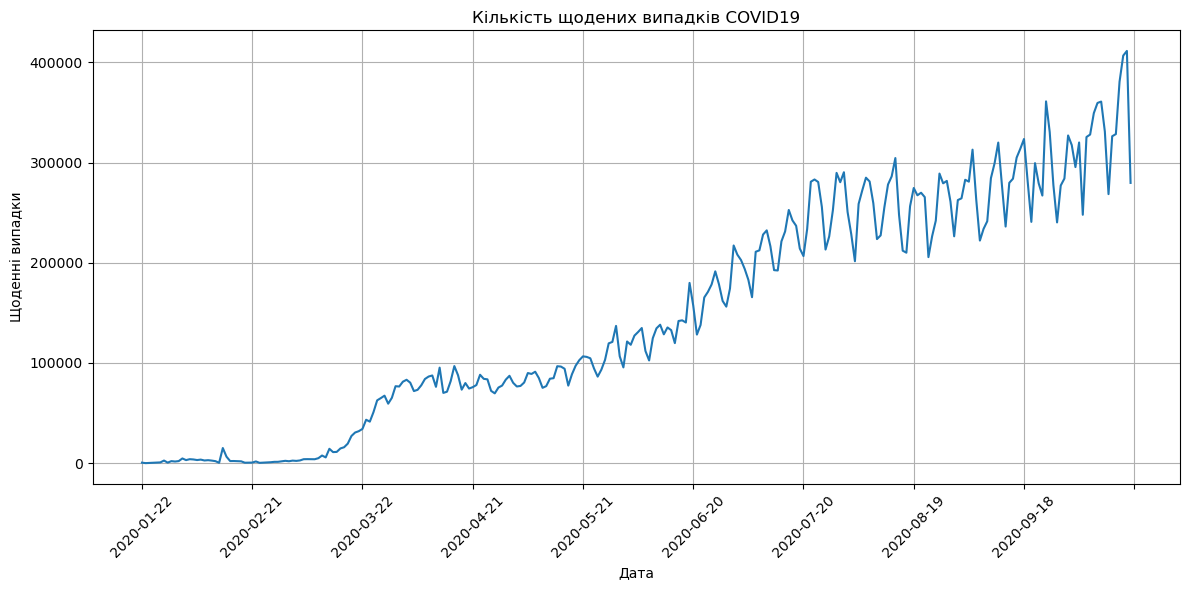

In [90]:
plot_per_dates(df['Date'], df['DailyConfirmed'], 'Кількість щодених випадків COVID19', 'Щоденні випадки')

### Перевірка на стаціонарність

In [91]:
fuller_test = adfuller(df['DailyConfirmed'])
print_fuller_test(fuller_test)

ADF=: 0.3588830608159112
p=: 0.9798904596242706
Часовий ряд не стаціонарний


Оскільки, часовий ряд не стаціонарний, потрібно його диференціювати.

In [92]:
df['Diff'] = df['DailyConfirmed'].diff()
df.loc[df.index[0], 'Diff'] = df['DailyConfirmed'].iloc[0]

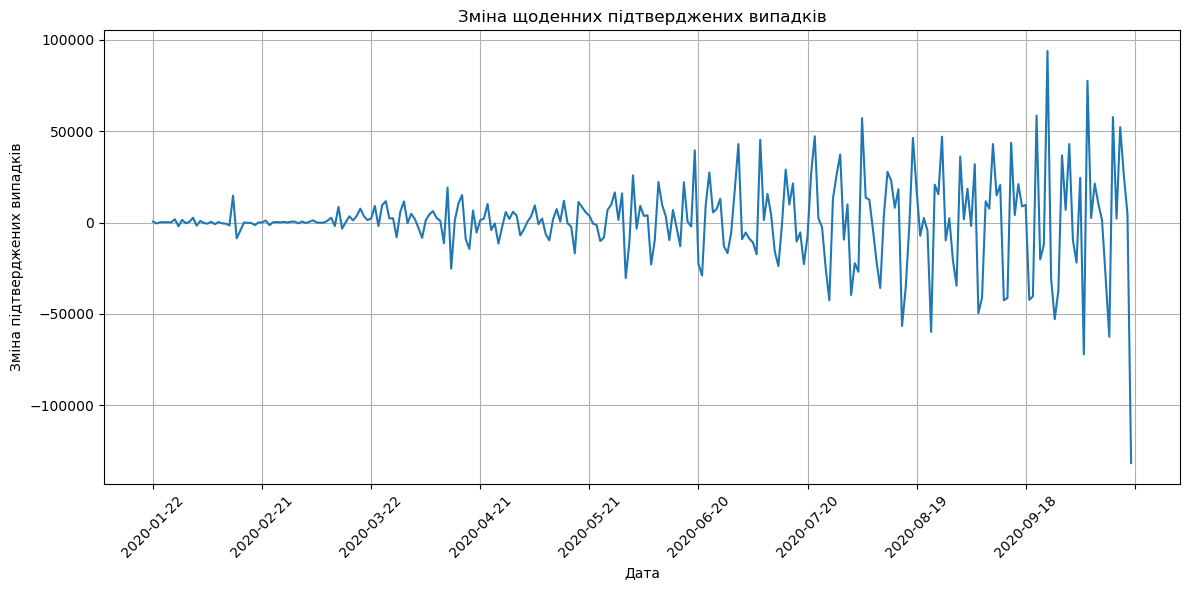

In [93]:
plot_per_dates(df['Date'], df['Diff'], 'Зміна щоденних підтверджених випадків', 'Зміна підтверджених випадків')

#### Перервірка на стаціонарність диференційованих даних

In [94]:
fuller_test_diff = adfuller(df['Diff'])
print_fuller_test(fuller_test_diff)

ADF=: -3.5166777812952272
p=: 0.007568962725692022
Часовий ряд стаціонарний


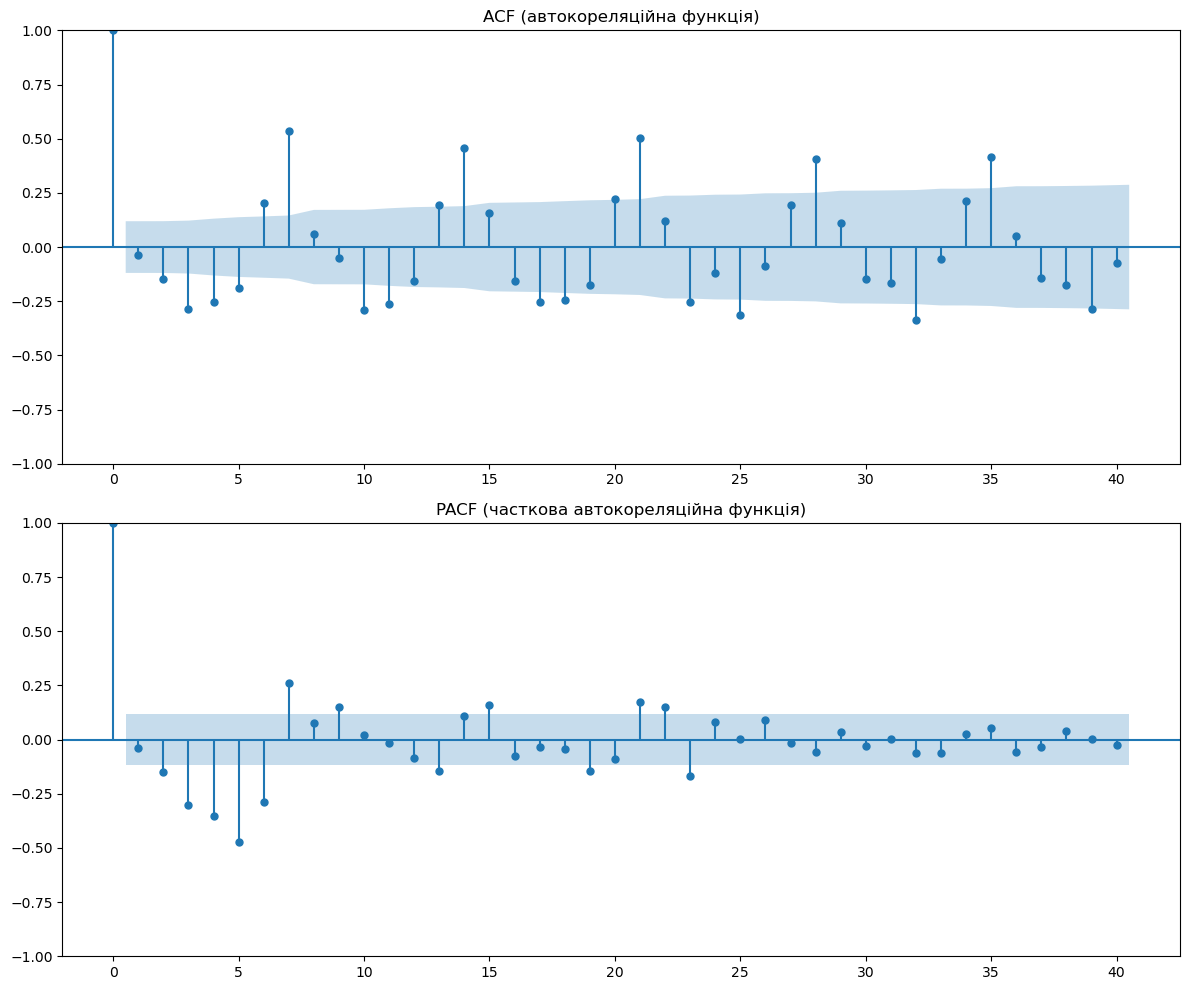

In [95]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df['Diff'], lags=40, ax=axes[0])
axes[0].set_title('ACF (автокореляційна функція)')
plot_pacf(df['Diff'], lags=40, ax=axes[1])
axes[1].set_title('PACF (часткова автокореляційна функція)')
plt.tight_layout()
plt.show()

### Розділення даних

In [96]:
train_size = int(len(df) * 0.75)
train, test = df.iloc[:train_size], df.iloc[train_size:]

## Алгоритм ARIMA

In [97]:
p, d, q = best_arima_coeffs(d=1, test=test, train=train, range_limit=5)

ARIMA(1, 1, 1) : AIC=4402.28, RMSE=73137.51
ARIMA(1, 1, 2) : AIC=4389.32, RMSE=61263.78
ARIMA(1, 1, 3) : AIC=4371.80, RMSE=59974.17
ARIMA(1, 1, 4) : AIC=4329.23, RMSE=57898.45
ARIMA(2, 1, 1) : AIC=4364.06, RMSE=57995.48
ARIMA(2, 1, 2) : AIC=4275.67, RMSE=48292.40
ARIMA(2, 1, 3) : AIC=4274.71, RMSE=44428.92
ARIMA(2, 1, 4) : AIC=4267.06, RMSE=44192.01
ARIMA(3, 1, 1) : AIC=4345.13, RMSE=55849.65
ARIMA(3, 1, 2) : AIC=4267.15, RMSE=44420.31
ARIMA(3, 1, 3) : AIC=4271.13, RMSE=48647.93
ARIMA(3, 1, 4) : AIC=4269.25, RMSE=44453.44
ARIMA(4, 1, 1) : AIC=4332.66, RMSE=54609.62
ARIMA(4, 1, 2) : AIC=4262.84, RMSE=44858.61
ARIMA(4, 1, 3) : AIC=4265.53, RMSE=44399.84
ARIMA(4, 1, 4) : AIC=4266.26, RMSE=44394.81
Найраща ARIMA(4, 1, 2); AIC=4262.84


In [98]:
model = ARIMA(train['DailyConfirmed'], order=(p, d, q))
model_fit = model.fit()

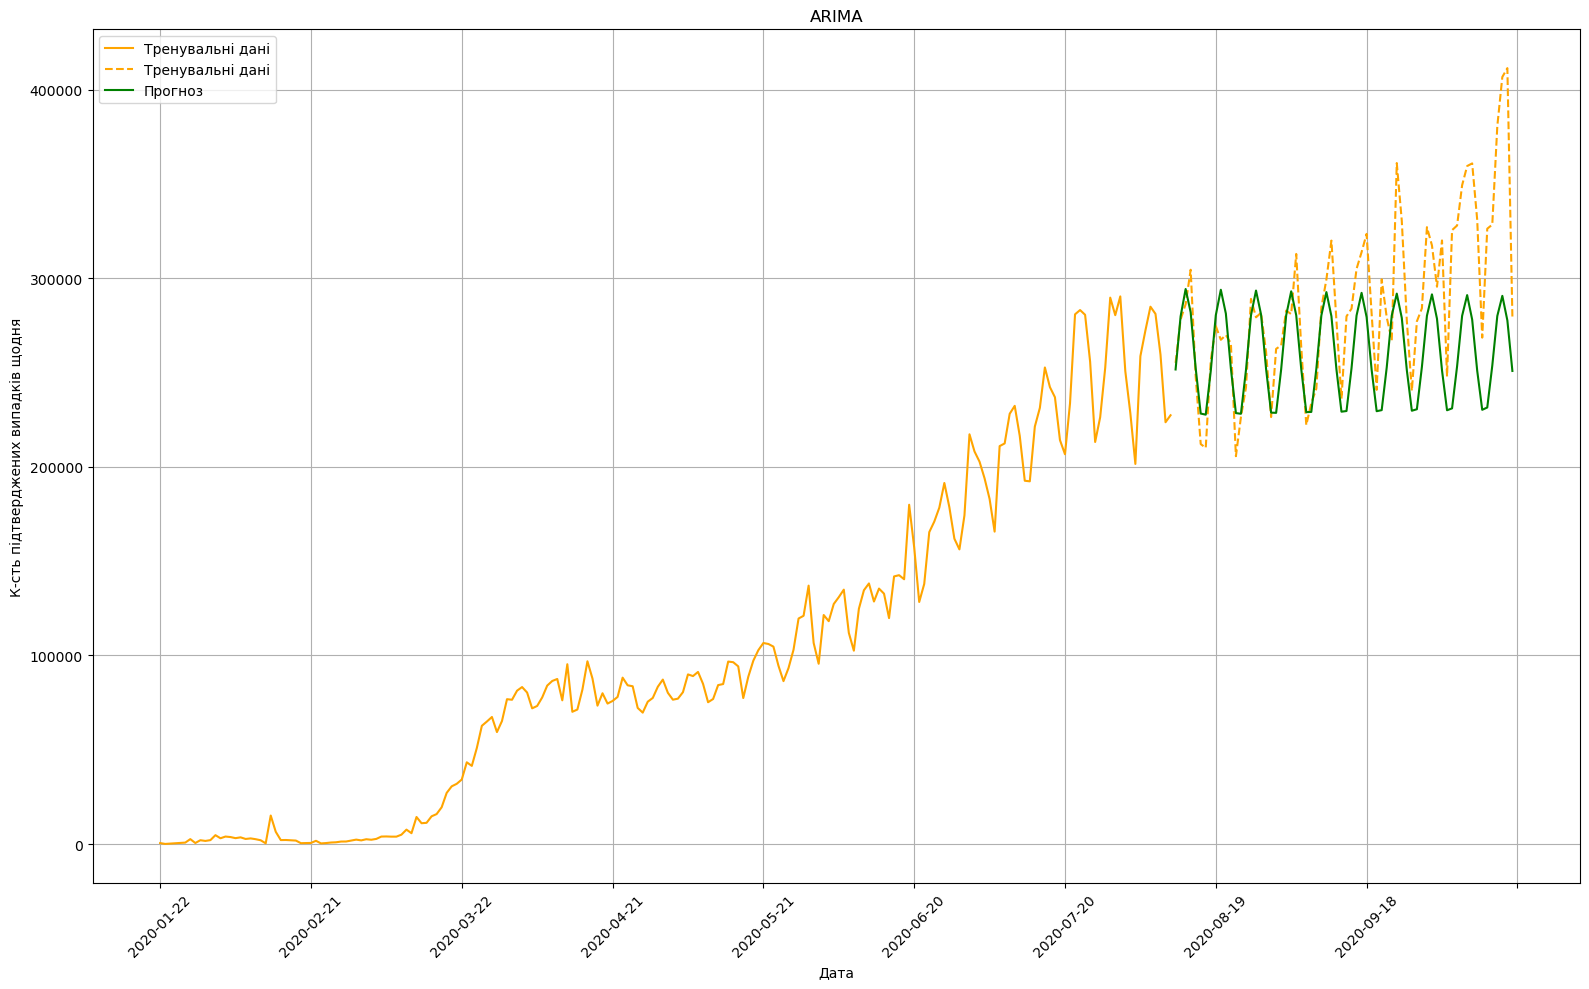

In [99]:
predict_arima = model_fit.forecast(steps=len(test))
plot_prediction(predict_arima, test, train, 'ARIMA')
rmses['ARIMA'] = rmse(test['DailyConfirmed'], predict_arima)

## Алгоритм ARMA

In [100]:
p,d,q = best_arima_coeffs(d=0, test=test, train=train, range_limit=5)

ARIMA(1, 0, 1) : AIC=4429.13, RMSE=120818.34
ARIMA(1, 0, 2) : AIC=4419.47, RMSE=64972.45
ARIMA(1, 0, 3) : AIC=4404.73, RMSE=67983.76
ARIMA(1, 0, 4) : AIC=4386.83, RMSE=59316.07
ARIMA(2, 0, 1) : AIC=4430.92, RMSE=119108.51
ARIMA(2, 0, 2) : AIC=4438.94, RMSE=123861.23
ARIMA(2, 0, 3) : AIC=4401.89, RMSE=66946.76
ARIMA(2, 0, 4) : AIC=4360.61, RMSE=68650.78
ARIMA(3, 0, 1) : AIC=4397.46, RMSE=64147.80
ARIMA(3, 0, 2) : AIC=4429.27, RMSE=112709.09
ARIMA(3, 0, 3) : AIC=4305.84, RMSE=49355.19
ARIMA(3, 0, 4) : AIC=4306.27, RMSE=47960.27
ARIMA(4, 0, 1) : AIC=4375.73, RMSE=60221.28
ARIMA(4, 0, 2) : AIC=4448.14, RMSE=107936.78
ARIMA(4, 0, 3) : AIC=4435.29, RMSE=65825.75
ARIMA(4, 0, 4) : AIC=4441.06, RMSE=105441.00
Найраща ARIMA(3, 0, 3); AIC=4305.84


In [101]:
model = ARIMA(train['DailyConfirmed'], order=(p, 0, q))
model_fit = model.fit()

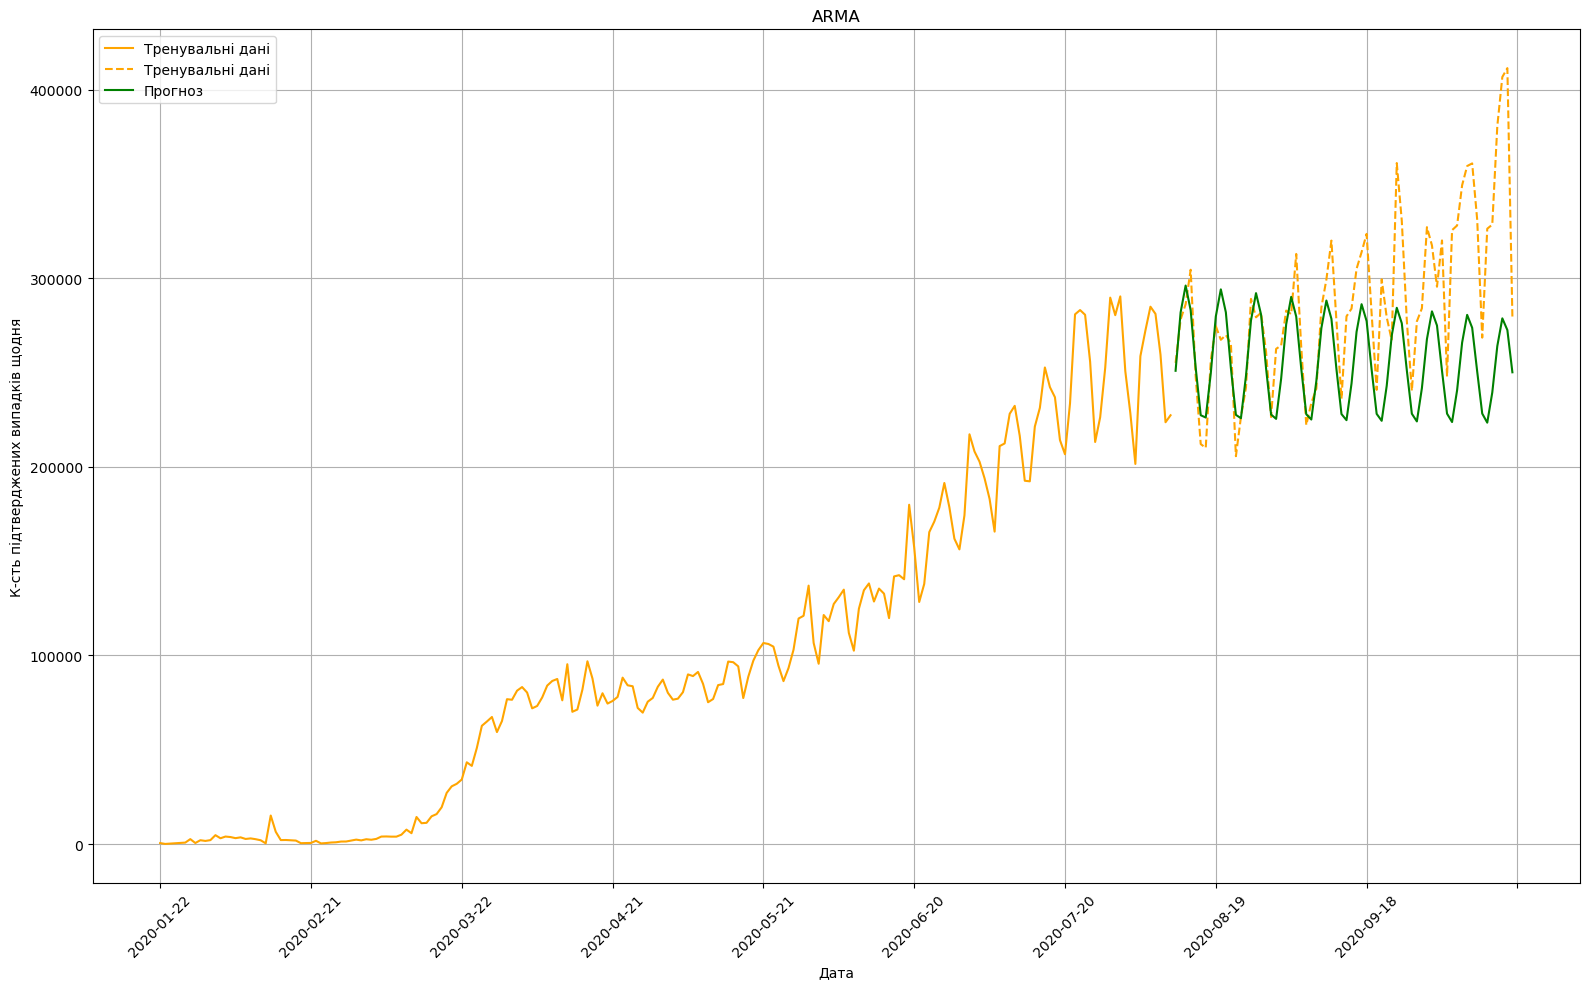

In [102]:
predict_arma = model_fit.forecast(steps=len(test))
plot_prediction(predict_arma, test, train, 'ARMA')
rmses['ARMA'] = rmse(test['DailyConfirmed'], predict_arma)

## Алгоритм ковзного середнього

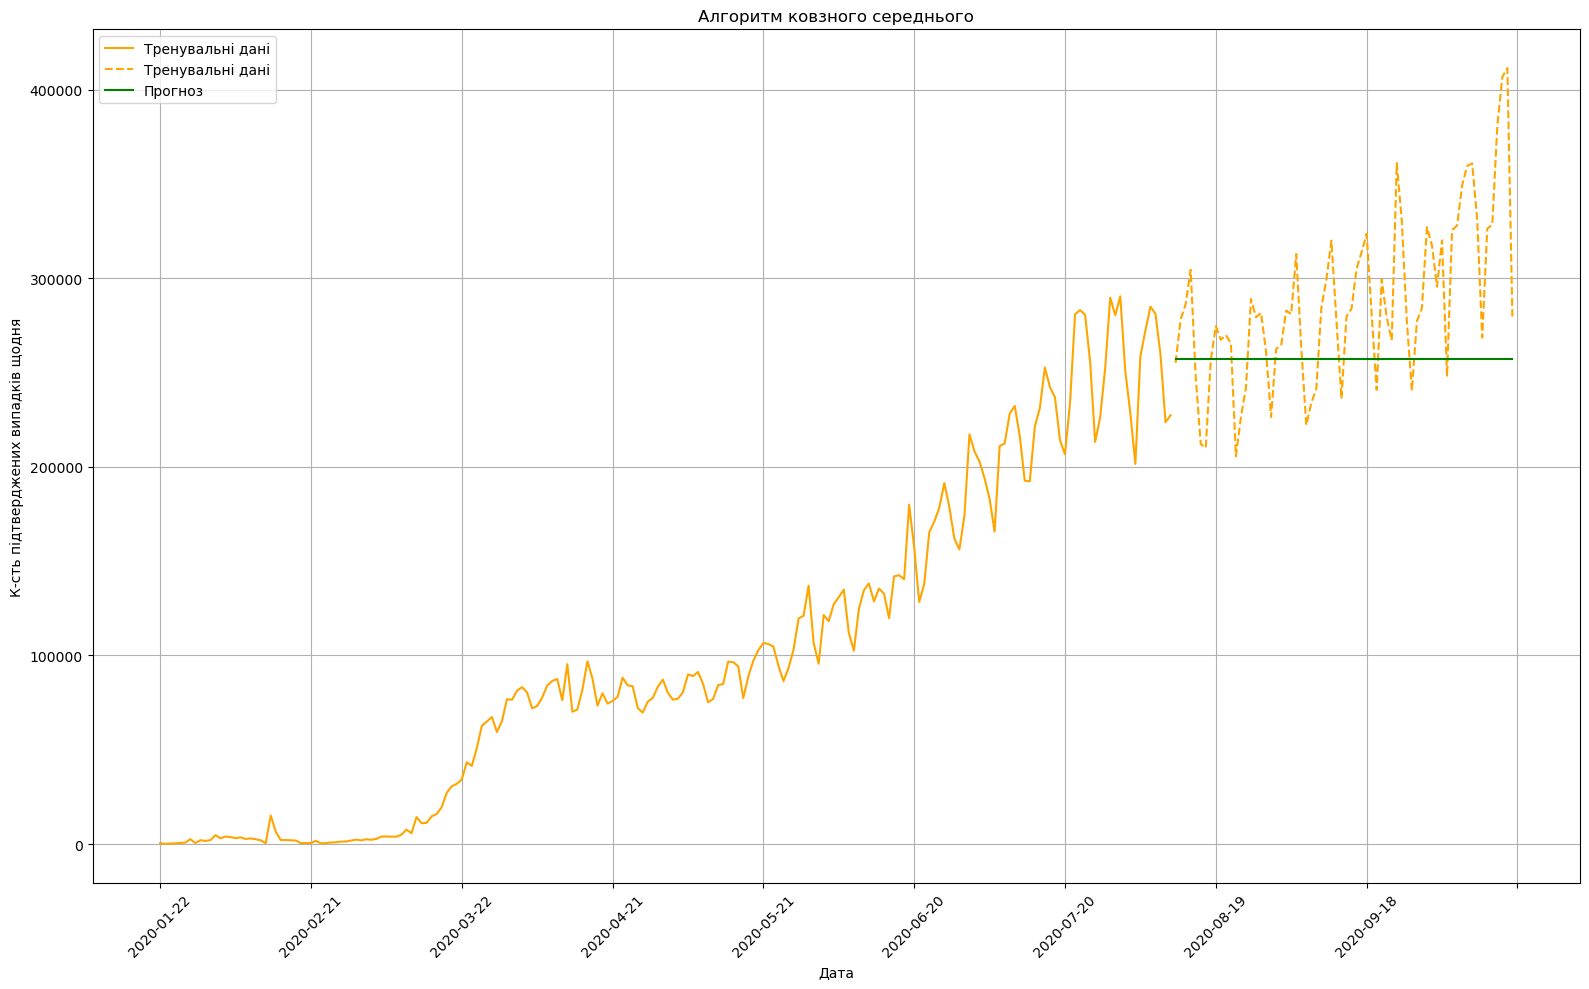

In [103]:
def moving_average(series, window, horizon):
    last_window = np.mean(series[-window:])
    return [last_window] * horizon

ma_window = 14
horizon = len(test)
ma_pred = moving_average(train['DailyConfirmed'], ma_window, horizon)

plot_prediction(ma_pred, test, train, 'Алгоритм ковзного середнього')

rmses['Алгоритм ковзного середнього'] = rmse(test['DailyConfirmed'], ma_pred)

## Алгоритм експоненційного згладжування

α=0.1, RMSE=58468.26
α=0.2, RMSE=57995.28
α=0.3, RMSE=60672.54
α=0.4, RMSE=63834.26
α=0.5, RMSE=67015.82
α=0.6, RMSE=69846.53
α=0.7, RMSE=72048.35
α=0.8, RMSE=73492.58
α=0.9, RMSE=74180.42
Найкращий α=0.2, RMSE=57995.28


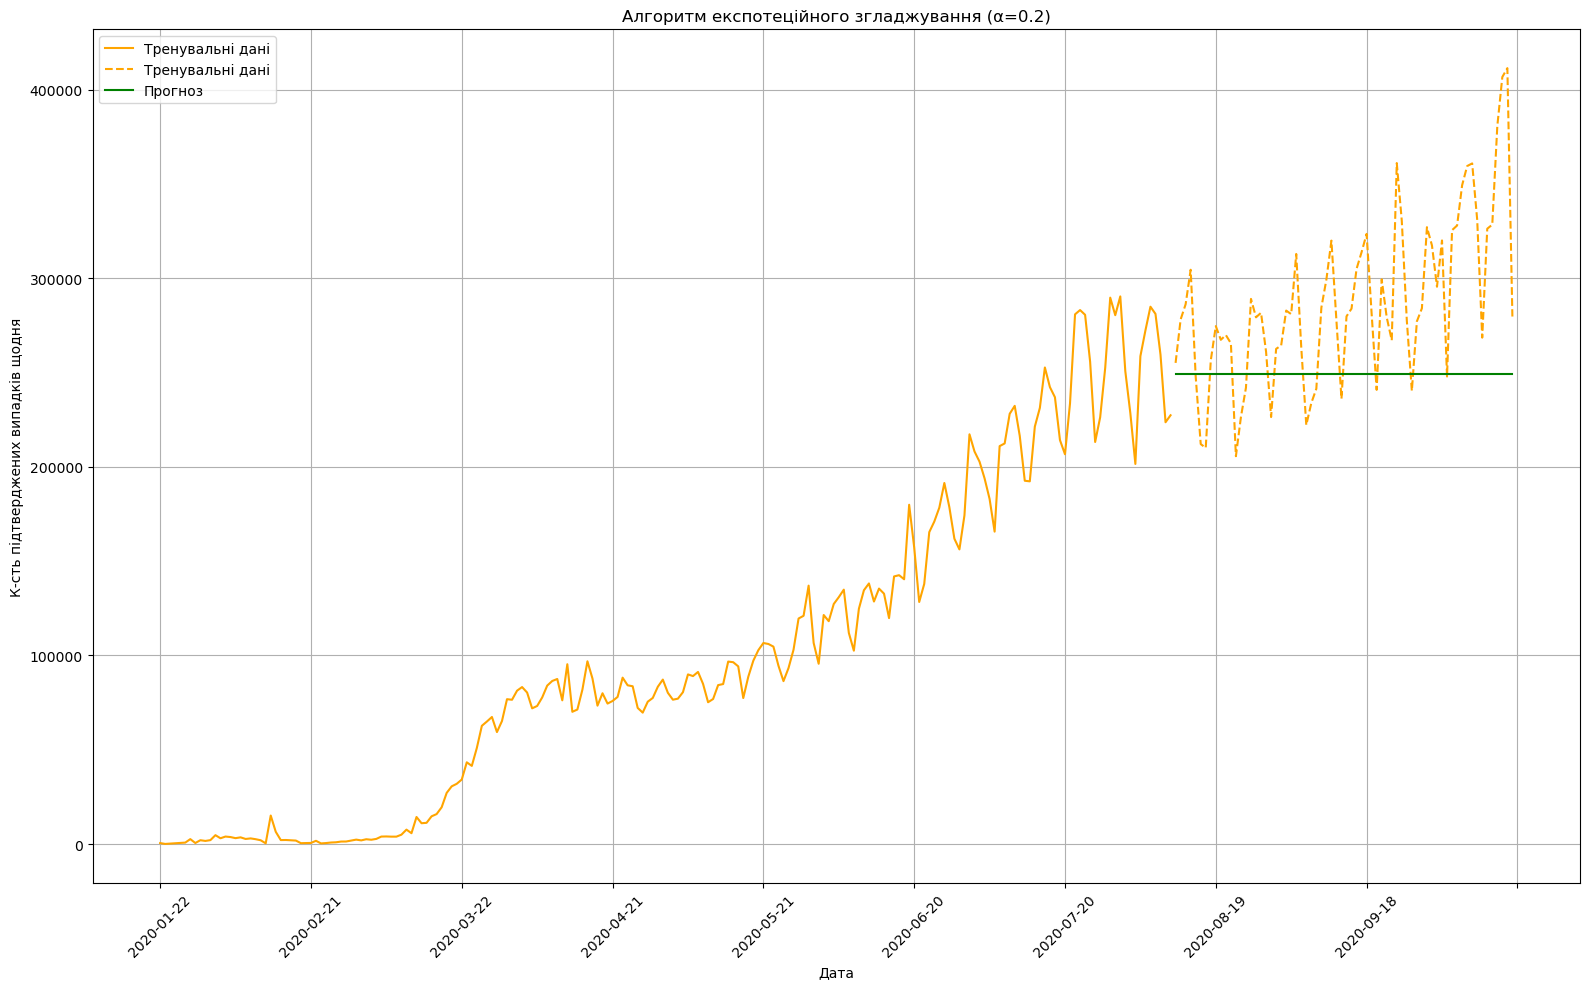

In [104]:
best_alpha = best_alpha(train, test)
model = SimpleExpSmoothing(train['DailyConfirmed'])
model_fit = model.fit(smoothing_level=best_alpha, optimized=False)
exp_pred = model_fit.forecast(len(test))
plot_prediction(exp_pred, test, train, f'Алгоритм експотеційного згладжування (α={best_alpha})')
rmses['Алгоритм експотеційного згладжування'] = rmse(test['DailyConfirmed'], exp_pred)

## Порівняння результатів

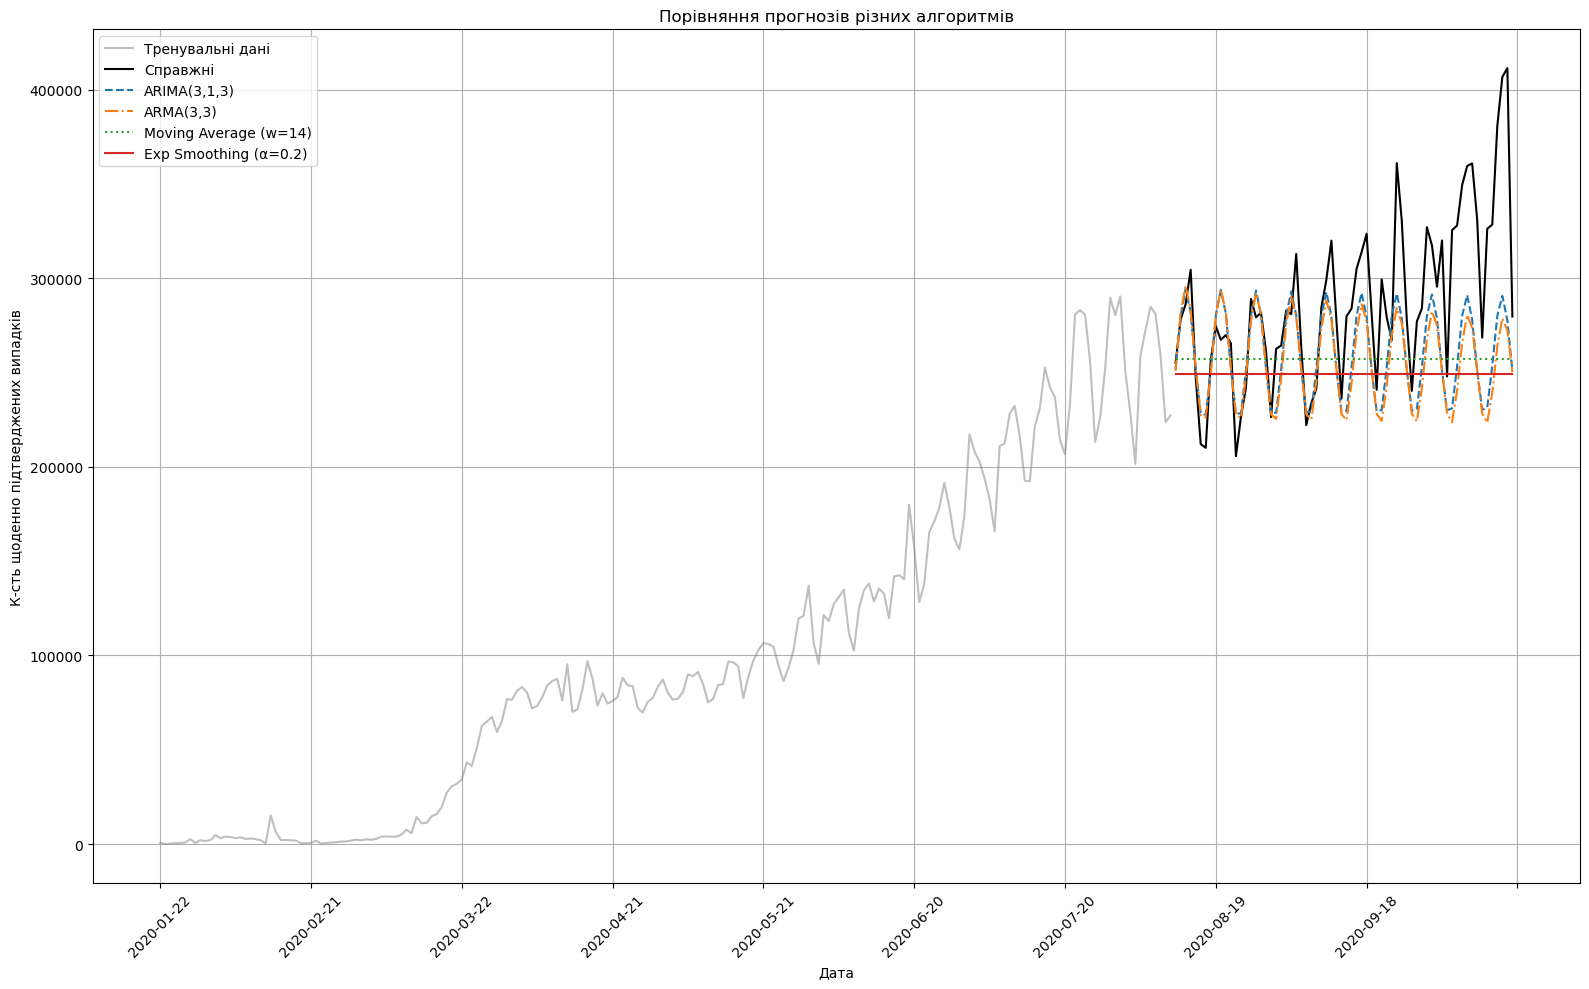

In [105]:
plt.figure(figsize=(16, 10))
plt.plot(train['Date'], train['DailyConfirmed'], label='Тренувальні дані', color='gray', alpha=0.5)
plt.plot(test['Date'], test['DailyConfirmed'], label='Справжні', color='black')
plt.plot(test['Date'], predict_arima, label=f'ARIMA({p},1,{q})', linestyle='--')
plt.plot(test['Date'], predict_arma, label=f'ARMA({p},{q})', linestyle='-.')
plt.plot(test['Date'], ma_pred, label=f'Moving Average (w={ma_window})', linestyle=':')
plt.plot(test['Date'], exp_pred, label=f'Exp Smoothing (α={best_alpha})', linestyle='-')
plt.xlabel('Дата')
plt.ylabel('К-сть щоденно підтверджених випадків')
plt.title('Порівняння прогнозів різних алгоритмів')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(11))
plt.tight_layout()
plt.show()

In [106]:
print('RMSE для різних моделей:')
for pair in rmses:
    print(f'{pair}: {rmses[pair]}')

RMSE для різних моделей:
ARIMA: 44858.60694012794
ARMA: 49355.18705504749
Алгоритм ковзного середнього: 53130.040757125724
Алгоритм експотеційного згладжування: 57995.27795978198
